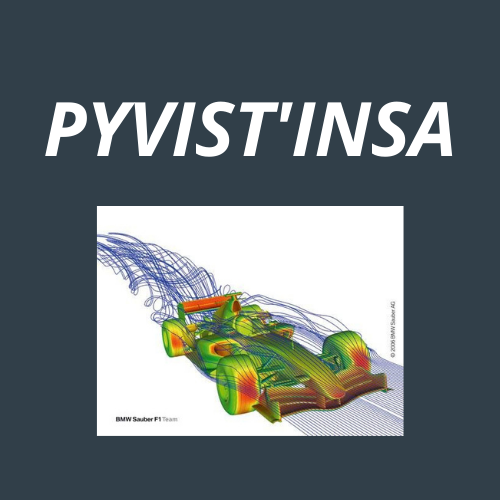

In [1]:
from IPython.display import display
import ipywidgets as widgets

In [2]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [3]:
%matplotlib widget

In [4]:
pv.Report()
# please make sure that your specs match those in the tutorial, particularly pyvista and vtk as some of the
# functions used in this code require that they be at least at the updates shown in the tutorial

--------------------------------------------------------------------------------
  Date: Fri Mar 11 20:13:31 2022 Paris, Madrid

                OS : Windows
            CPU(s) : 8
           Machine : AMD64
      Architecture : 64bit
               RAM : 7.8 GiB
       Environment : Jupyter
        GPU Vendor : Intel
      GPU Renderer : Intel(R) UHD Graphics
       GPU Version : 4.5.0 - Build 26.20.100.7584

  Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]

           pyvista : 0.33.dev0
               vtk : 9.1.0
             numpy : 1.20.1
           imageio : 2.9.0
           appdirs : 1.4.4
            scooby : 0.5.7
        matplotlib : 3.3.4
             PyQt5 : 5.9.2
           IPython : 7.22.0
        ipyvtklink : 0.2.1
             scipy : 1.6.2
              tqdm : 4.59.0
            meshio : 4.4.6

  Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

In [5]:
# separates and names all 9 components of the gradient tensor
def gradients_to_dict(arr):
    keys = np.array(["dux/dx", "dux/dy", "dux/dz", "duy/dx", "duy/dy", "duy/dz", "duz/dx", "duz/dy", "duz/dz"])
    keys = keys.reshape((3,3))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

# separates and names all 3 components of the gradient vector calculated from the velocity magnitude (U-normed)
def gradients_to_dict2(arr):
    keys = np.array(["dU/dx", "dU/dy", "dU/dz"])
    keys = keys.reshape((3,1))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

# separates and names all 3 components of the vorticity vector 
def vorticity_to_dict(arr):
    keys = np.array(["vort_x", "vort_y", "vort_z"])
    keys = keys.reshape((3,1))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

# plots a scalar field of choice from the internalMesh
def plot_internalMesh(field, edges):
    p = pv.Plotter()
    p.add_mesh(internalMesh ,scalars=field, show_edges=edges)
    # if show_edges is set to True, the mesh will be surimposed on the domain
    p.view_xy()
    p.add_axes()
    p.show()
    
# plots a scalar field of choice from mesh_cell   
def plot_cell(field, edges):
    p = pv.Plotter()
    p.add_mesh(mesh_cell ,scalars=field, show_edges=edges)
    # if show_edges is set to True, the mesh will be surimposed on the domain
    p.view_xy()
    p.add_axes()
    p.show()
    
# plots a scalar field of choice from mesh_point
def plot_point(field, edges):
    p = pv.Plotter()
    p.add_mesh(mesh_point ,scalars=field, show_edges=edges)
    # if show_edges is set to True, the mesh will be surimposed on the domain
    p.view_xy()
    p.add_axes()
    p.show()
    
# plots the velocity vector field from the data from the internalMesh    
def plot_vectors(scale, factor):
    geom = pv.Arrow()
    glyphs = internalMesh.glyph(orient='U', scale=scale, factor=factor, geom=geom)
    # we can scale our vectors with the scale function.
    # when set to True, it uses the active scalars to scale the glyphs. The scaling vectors can also be specified by the user
    # when set to False, the glyphs won't be scaled
    p = pv.Plotter()
    p.add_mesh(glyphs)
    p.view_xy()
    p.add_axes()
    p.show()

# plots the velocity vector field from the data from mesh_cell
def plot_vectors_cell(scale, factor):
    geom = pv.Arrow()
    glyphs = mesh_cell.glyph(orient='U', scale=scale, factor=factor, geom=geom)
    # we can scale our vectors with the scale function.
    # when set to True, it uses the active scalars to scale the glyphs. The scaling vectors can also be specified by the user
    # when set to False, the glyphs won't be scaled
    p = pv.Plotter()
    p.add_mesh(glyphs)
    p.view_xy()
    p.add_axes()
    p.show()
    
# plots the velocity vector field from the data from mesh_point
def plot_vectors_point(scale, factor):
    geom = pv.Arrow()
    glyphs = mesh_point.glyph(orient='U', scale=scale, factor=factor, geom=geom)
    # we can scale our vectors with the scale function.
    # when set to True, it uses the active scalars to scale the glyphs. The scaling vectors can also be specified by the user
    # when set to False, the glyphs won't be scaled
    p = pv.Plotter()
    p.add_mesh(glyphs)
    p.view_xy()
    p.add_axes()
    p.show()

<a class="anchor" id="home"></a>

<h1 style ="font-size:300%;text-align:center">Table of Contents</h1>

* [Load the case with OpenFOAMReader](#chapter1)
* [Two datasets : cell data and point data](#chapter2)
* [Show the mesh](#chapter3)
* [Let's plot our fields](#chapter4)
* [Plot the velocity field using glyphs](#chapter5)   
* [How to access the vector components](#chapter6)
* [Let's plot the streamlines](#chapter7)
* [Let's calculate the gradients and vorticity](#chapter8)
* [Let's plot the gradient components](#chapter9)
* [Let's plot the vorticity components](#chapter10)
* [Vectors normalization compared to the maximal component](#chapter11)
* [Let's plot all of our fields](#chapter12)
* [How to plot over a line](#chapter13)
* [Plot a scalar over a circular arc](#chapter14)
* [Wall shear stress](#chapter15)

<a class="anchor" id="chapter1"></a>

# Load the case with `OpenFOAMReader`

In [6]:
reader = pv.OpenFOAMReader("C:/Users/pret/Desktop/INSA HDF 5A/PLP 5A/OpenFOAM_example_case/case.foam")
# pv.OpenFOAMReader takes the path of the empty .foam file of the simulation as argument (replace all \ with /)
reader.cell_to_point_creation = False
# When set to True, copies cell data and creates point data from it
# When set to False, only cell data is read
time = reader.time_values # this list will contain all the time values of the simulation
print(time)

[0.0, 500.0, 1000.0]


In [7]:
reader.enable_all_patch_arrays() # enables all the patches, including the boundaries
reader.set_active_time_value(time[2]) # set time at whichever value we want to visualise
multi_block = reader.read() # multi_block contains all the relevant data (internalMesh and Boundary)
print(multi_block.keys())
multi_block 

['internalMesh', 'boundary']


MultiBlock (0x1e09a051dc0)
  N Blocks:	2
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

This `MultiBlock` contains all the relevant data from the simulation within two blocks:<br/> 
* One that contains all the data from the `internalMesh`
* One that contains all the data from the boundaries.

In [8]:
internalMesh = multi_block[0] # this contains all the data from the internalMesh
internalMesh

UnstructuredGrid (0x1e09a051d00)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [9]:
boundary = multi_block[1] # this contains all the data from the boundaries
boundary

MultiBlock (0x1e09a051220)
  N Blocks:	5
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

In [10]:
merged = boundary.combine(merge_points=False, tolerance=0.0)
# this allows us to combine all the boundaries together in one UnstructuredGrid
fullMesh = internalMesh.merge(merged, merge_points=True, inplace=False, main_has_priority=False, progress_bar=False)
# this allows us to get one complete mesh that contains both the internalMesh and the boundaries
fullMesh

UnstructuredGrid (0x1e09a02e160)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

What we call `fullMesh` contains the data from the entire domain in the form of cell data.

<a class="anchor" id="chapter2"></a>

# Two datasets : cell data and point data

Let's create two datasets:<br/> 
* One that only contains the cell data
* One that only contains the point data.

The datasets will be derived from the `fullMesh`

In [11]:
mesh_cell = fullMesh
mesh_point = mesh_cell.cell_data_to_point_data() # converts cell data into point data 
mesh_cell # contains all the cell data from the fullMesh

UnstructuredGrid (0x1e09a02e160)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [12]:
mesh_point # contains all the point data from the fullMesh

UnstructuredGrid (0x1e09a02efa0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

From now on, we will plot the data from `internalMesh`, `mesh_cell` and `mesh_point`.

<a class="anchor" id="chapter3"></a>

# Show the mesh 

In [13]:
# Create a plotting object to display vtk meshes or numpy arrays
p = pv.Plotter()
# Show the mesh in wireframe style
p.add_mesh(fullMesh, style="wireframe", color="w")
# View in the xy plane
p.view_xy()
# Show the axes
p.add_axes()
# Display the plotting window
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter4"></a>

# Let's plot our fields 

Our code calculates `U-normed`, the velocity magnitude, automatically when plotting the velocity scalar field.<br/>
In order to plot `U-normed` later on, we start by plotting the `U` field without displaying it.<br/>
We'll do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [14]:
p = pv.Plotter()
p.add_mesh(internalMesh ,scalars='U', show_edges=True)
# if show_edges is set to True, the mesh will be surimposed on the domain

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001E08C3BC890) at 0x000001E0A21C8340>

In [15]:
p = pv.Plotter()
p.add_mesh(mesh_cell ,scalars='U', show_edges=True)
# if show_edges is set to True, the mesh will be surimposed on the domain

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001E08C3BF090) at 0x000001E0A21DC3A0>

In [16]:
p = pv.Plotter()
p.add_mesh(mesh_point ,scalars='U', show_edges=True)
# if show_edges is set to True, the mesh will be surimposed on the domain

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001E08C3BF290) at 0x000001E0A21E5100>

Now, we can plot all of the scalar fields that have been calculated during the simulation.

In [17]:
widgets.interact(plot_internalMesh, field=internalMesh.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_internalMesh(field, edges)>

In [18]:
widgets.interact(plot_cell, field=mesh_cell.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_cell(field, edges)>

In [19]:
widgets.interact(plot_point, field=mesh_point.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_point(field, edges)>

<a class="anchor" id="chapter5"></a>

# Plot the velocity field using glyphs

We can do the same, but with the velocity vector field as well.<br/>
We can scale the vectors with any of the scalar fields available.<br/>
To plot the actual velocity vector field, we need to scale the vectors using `U-normed`

In [20]:
widgets.interact(plot_vectors, scale=internalMesh.array_names, factor=widgets.fixed(0.0005))

interactive(children=(Dropdown(description='scale', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_vectors(scale, factor)>

In [21]:
widgets.interact(plot_vectors_cell, scale=mesh_cell.array_names, factor=widgets.fixed(0.0005))

interactive(children=(Dropdown(description='scale', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_vectors_cell(scale, factor)>

In [22]:
widgets.interact(plot_vectors_point, scale=mesh_point.array_names, factor=widgets.fixed(0.0005))

interactive(children=(Dropdown(description='scale', options=('U-normed', 'U', 'epsilon', 'k', 'nut', 'p'), val…

<function __main__.plot_vectors_point(scale, factor)>

<a class="anchor" id="chapter6"></a>

# How to access the vector components

We can access every component of the velocity vector field separately.<br/>
This can be particularly useful if we need to plot each component.<br/>
We'll do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [23]:
ux = internalMesh['U'][:,0]
uy = internalMesh['U'][:,1]
uz = internalMesh['U'][:,2]

internalMesh.cell_data["ux"] = ux
internalMesh.cell_data["uy"] = uy
internalMesh.cell_data["uz"] = uz

internalMesh

UnstructuredGrid (0x1e09a051d00)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

In [24]:
ux = mesh_cell['U'][:,0]
uy = mesh_cell['U'][:,1]
uz = mesh_cell['U'][:,2]

mesh_cell.cell_data["ux"] = ux
mesh_cell.cell_data["uy"] = uy
mesh_cell.cell_data["uz"] = uz

mesh_cell

UnstructuredGrid (0x1e09a02e160)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

In [25]:
ux = mesh_point['U'][:,0]
uy = mesh_point['U'][:,1]
uz = mesh_point['U'][:,2]

mesh_point.point_data["ux"] = ux
mesh_point.point_data["uy"] = uy
mesh_point.point_data["uz"] = uz

mesh_point

UnstructuredGrid (0x1e09a02efa0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

<a class="anchor" id="chapter7"></a>

# Let's plot the streamlines

Now, we'll plot the streamlines of our flow.<br/>
This can only be done using point data, so we'll only plot the streamlines using the data from `mesh_point`.

In [26]:
face = mesh_point.slice(normal='x') # "normal" should be set as the direction of the flow
str = mesh_point.streamlines_from_source(face, vectors='U') # creates streamlines from a singular surface

In [27]:
p = pv.Plotter()
p.add_mesh(mesh_point, color="w")
p.add_mesh(str.tube(radius=0.0004))
# View in the xy plane
p.view_xy()
# Show the axes
p.add_axes()
# Display the plotting window
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter8"></a>

# Let's calculate the gradients and vorticity 

Let us first create a list of labels so that we can order our gradient and vorticity components:

In [28]:
Labels = ["dU/dx", "dU/dy", "dU/dz", "dux/dx", "dux/dy", "dux/dz", "duy/dx", "duy/dy", "duy/dz", "duz/dx", "duz/dy", "duz/dz",
         "vort_x", "vort_y", "vort_z"]

After that, we calculate the gradient and vorticity components.<br/>
We'll do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [29]:
# deriv will contain the data from the gradient of U (9 components)
deriv = internalMesh.compute_derivative(scalars='U', gradient=True, divergence=None, vorticity=True, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2 = internalMesh.compute_derivative(scalars="U-normed", gradient=True, divergence=None, vorticity=False, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)

In [30]:
grad = gradients_to_dict(deriv["gradient"])
grad2 = gradients_to_dict2(deriv2["gradient"])
vort = vorticity_to_dict(deriv["vorticity"])

for i in range(0, 3):
    internalMesh.cell_data[Labels[i]] = grad2[Labels[i]]
for i in range(3, 12):
    internalMesh.cell_data[Labels[i]] = grad[Labels[i]]
for i in range(12, 15):
    internalMesh.cell_data[Labels[i]] = vort[Labels[i]]

internalMesh

UnstructuredGrid (0x1e09a051d00)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	24

In [31]:
# deriv will contain the data from the gradient of U (9 components)
deriv_cell = mesh_cell.compute_derivative(scalars='U', gradient=True, divergence=None, vorticity=True, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_cell = mesh_cell.compute_derivative(scalars="U-normed", gradient=True, divergence=None, vorticity=False, 
                                          qcriterion=None, faster=False, preference='cell', progress_bar=False)

In [32]:
grad_cell = gradients_to_dict(deriv_cell["gradient"])
grad2_cell = gradients_to_dict2(deriv2_cell["gradient"])
vort_cell = vorticity_to_dict(deriv_cell["vorticity"])

for i in range(0, 3):
    mesh_cell.cell_data[Labels[i]] = grad2_cell[Labels[i]]
for i in range(3, 12):
    mesh_cell.cell_data[Labels[i]] = grad_cell[Labels[i]]
for i in range(12, 15):
    mesh_cell.cell_data[Labels[i]] = vort_cell[Labels[i]]

mesh_cell

UnstructuredGrid (0x1e09a02e160)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	24

In [33]:
# deriv will contain the data from the gradient of U (9 components)
deriv_point = mesh_point.compute_derivative(scalars='U', gradient=True, divergence=None, vorticity=True, 
                                          qcriterion=None, faster=False, preference='point', progress_bar=False)
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_point = mesh_point.compute_derivative(scalars="U-normed", gradient=True, divergence=None, vorticity=False, 
                                          qcriterion=None, faster=False, preference='point', progress_bar=False)

In [34]:
grad_point = gradients_to_dict(deriv_point["gradient"])
grad2_point = gradients_to_dict2(deriv2_point["gradient"])
vort_point = vorticity_to_dict(deriv_point["vorticity"])

for i in range(0, 3):
    mesh_point.point_data[Labels[i]] = grad2_point[Labels[i]]
for i in range(3, 12):
    mesh_point.point_data[Labels[i]] = grad_point[Labels[i]]
for i in range(12, 15):
    mesh_point.point_data[Labels[i]] = vort_point[Labels[i]]

mesh_point

UnstructuredGrid (0x1e09a02efa0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	24

<a class="anchor" id="chapter9"></a>

# Let's plot the gradient components 

In [80]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

i = 3
for j in range (0, 3):
    for k in range (0, 3):
        plotter.subplot(j, k)
        plotter.add_text(Labels[i], font_size=20)
        plotter.add_mesh(internalMesh.copy(),scalars=Labels[i])
        plotter.view_xy()
        plotter.add_axes()
        
        i = i + 1

plotter.show()        

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [36]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

i = 3
for j in range (0, 3):
    for k in range (0, 3):
        plotter.subplot(j, k)
        plotter.add_text(Labels[i], font_size=20)
        plotter.add_mesh(mesh_cell.copy(),scalars=Labels[i])
        plotter.view_xy()
        plotter.add_axes()
        
        i = i + 1

plotter.show() 

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [37]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

i = 3
for j in range (0, 3):
    for k in range (0, 3):
        plotter.subplot(j, k)
        plotter.add_text(Labels[i], font_size=20)
        plotter.add_mesh(mesh_point.copy(),scalars=Labels[i])
        plotter.view_xy()
        plotter.add_axes()
        
        i = i + 1

plotter.show() 

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter10"></a>

# Let's plot the vorticity components

In [81]:
pv.set_plot_theme("document")

### multiplot, plotting of vorticity components (internalMesh)

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x", font_size=20)
plotter.add_mesh(internalMesh,scalars="vort_x")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="vort_y")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="vort_z")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [39]:
### multiplot, plotting of vorticity components (cell data)

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x", font_size=20)
plotter.add_mesh(mesh_cell,scalars="vort_x")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_y")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_z")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [40]:
### multiplot, plotting of vorticity components (point data)

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x", font_size=20)
plotter.add_mesh(mesh_point,scalars="vort_x")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_y")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_z")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter11"></a>

# Vectors normalization compared to the maximal component 

As shown earlier, we can plot all the gradient components and vorticity components together in two multiplots: one for the gradient components and one for the vorticity components.<br/>
In order to compare these plots with each other more efficiently, what we can do is normalize these fields so as to have the same variation scale for all the components.<br/>
We'll do this for the data in `internalMesh`, `mesh_cell` and `mesh_point`.

In [41]:
duxdx_norm=(internalMesh["dux/dx"]-min(internalMesh["dux/dx"]))/(max(internalMesh["dux/dx"])-min(internalMesh["dux/dx"]))
duydx_norm=(internalMesh["duy/dx"]-min(internalMesh["duy/dx"]))/(max(internalMesh["duy/dx"])-min(internalMesh["duy/dx"]))
duzdx_norm=(internalMesh["duz/dx"]-min(internalMesh["duz/dx"]))/(max(internalMesh["duz/dx"])-min(internalMesh["duz/dx"]))
duxdy_norm=(internalMesh["dux/dy"]-min(internalMesh["dux/dy"]))/(max(internalMesh["dux/dy"])-min(internalMesh["dux/dy"]))
duydy_norm=(internalMesh["duy/dy"]-min(internalMesh["duy/dy"]))/(max(internalMesh["duy/dy"])-min(internalMesh["duy/dy"]))
duzdy_norm=(internalMesh["duz/dy"]-min(internalMesh["duz/dy"]))/(max(internalMesh["duz/dy"])-min(internalMesh["duz/dy"]))
#duxdz_norm=(internalMesh["dux/dz"]-min(internalMesh["dux/dz"]))/(max(internalMesh["dux/dz"])-min(internalMesh["dux/dz"]))
#duydz_norm=(internalMesh["duy/dz"]-min(internalMesh["duy/dz"]))/(max(internalMesh["duy/dz"])-min(internalMesh["duy/dz"]))
#duzdz_norm=(internalMesh["duz/dz"]-min(internalMesh["duz/dz"]))/(max(internalMesh["duz/dz"])-min(internalMesh["duz/dz"]))
vort_x_norm=(internalMesh["vort_x"]-min(internalMesh["vort_x"]))/(max(internalMesh["vort_x"])-min(internalMesh["vort_x"]))
vort_y_norm=(internalMesh["vort_y"]-min(internalMesh["vort_y"]))/(max(internalMesh["vort_y"])-min(internalMesh["vort_y"]))
vort_z_norm=(internalMesh["vort_z"]-min(internalMesh["vort_z"]))/(max(internalMesh["vort_z"])-min(internalMesh["vort_z"]))

In the case of a 2D simulation, the velocity gradient in the direction perpendicular to the plane of the flow is null. This means that the normalization method used here won't work, as it would require us to divide by zero.

In [42]:
internalMesh.cell_data["dux/dx n"] = duxdx_norm
internalMesh.cell_data["duy/dx n"] = duydx_norm
internalMesh.cell_data["duz/dx n"] = duzdx_norm
internalMesh.cell_data["dux/dy n"] = duxdy_norm
internalMesh.cell_data["duy/dy n"] = duydy_norm
internalMesh.cell_data["duz/dy n"] = duzdy_norm
#internalMesh.cell_data["dux/dz n"] = duxdz_norm
#internalMesh.cell_data["duy/dz n"] = duydz_norm
#internalMesh.cell_data["duz/dz n"] = duzdz_norm
internalMesh.cell_data["vort_x n"] = vort_x_norm
internalMesh.cell_data["vort_y n"] = vort_y_norm
internalMesh.cell_data["vort_z n"] = vort_z_norm

In [43]:
internalMesh

UnstructuredGrid (0x1e09a051d00)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	33

In [44]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(internalMesh,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [45]:
### multiplot

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x n", font_size=20)
plotter.add_mesh(internalMesh, scalars="vort_x n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="vort_y n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z n", font_size=20)
plotter.add_mesh(internalMesh.copy(),scalars="vort_z n")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [46]:
duxdx_norm=(mesh_cell["dux/dx"]-min(mesh_cell["dux/dx"]))/(max(mesh_cell["dux/dx"])-min(mesh_cell["dux/dx"]))
duydx_norm=(mesh_cell["duy/dx"]-min(mesh_cell["duy/dx"]))/(max(mesh_cell["duy/dx"])-min(mesh_cell["duy/dx"]))
duzdx_norm=(mesh_cell["duz/dx"]-min(mesh_cell["duz/dx"]))/(max(mesh_cell["duz/dx"])-min(mesh_cell["duz/dx"]))
duxdy_norm=(mesh_cell["dux/dy"]-min(mesh_cell["dux/dy"]))/(max(mesh_cell["dux/dy"])-min(mesh_cell["dux/dy"]))
duydy_norm=(mesh_cell["duy/dy"]-min(mesh_cell["duy/dy"]))/(max(mesh_cell["duy/dy"])-min(mesh_cell["duy/dy"]))
duzdy_norm=(mesh_cell["duz/dy"]-min(mesh_cell["duz/dy"]))/(max(mesh_cell["duz/dy"])-min(mesh_cell["duz/dy"]))
#duxdz_norm=(mesh_cell["dux/dz"]-min(mesh_cell["dux/dz"]))/(max(mesh_cell["dux/dz"])-min(mesh_cell["dux/dz"]))
#duydz_norm=(mesh_cell["duy/dz"]-min(mesh_cell["duy/dz"]))/(max(mesh_cell["duy/dz"])-min(mesh_cell["duy/dz"]))
#duzdz_norm=(mesh_cell["duz/dz"]-min(mesh_cell["duz/dz"]))/(max(mesh_cell["duz/dz"])-min(mesh_cell["duz/dz"]))
vort_x_norm=(mesh_cell["vort_x"]-min(mesh_cell["vort_x"]))/(max(mesh_cell["vort_x"])-min(mesh_cell["vort_x"]))
vort_y_norm=(mesh_cell["vort_y"]-min(mesh_cell["vort_y"]))/(max(mesh_cell["vort_y"])-min(mesh_cell["vort_y"]))
vort_z_norm=(mesh_cell["vort_z"]-min(mesh_cell["vort_z"]))/(max(mesh_cell["vort_z"])-min(mesh_cell["vort_z"]))

In [47]:
mesh_cell.cell_data["dux/dx n"] = duxdx_norm
mesh_cell.cell_data["duy/dx n"] = duydx_norm
mesh_cell.cell_data["duz/dx n"] = duzdx_norm
mesh_cell.cell_data["dux/dy n"] = duxdy_norm
mesh_cell.cell_data["duy/dy n"] = duydy_norm
mesh_cell.cell_data["duz/dy n"] = duzdy_norm
#mesh_cell.cell_data["dux/dz n"] = duxdz_norm
#mesh_cell.cell_data["duy/dz n"] = duydz_norm
#mesh_cell.cell_data["duz/dz n"] = duzdz_norm
mesh_cell.cell_data["vort_x n"] = vort_x_norm
mesh_cell.cell_data["vort_y n"] = vort_y_norm
mesh_cell.cell_data["vort_z n"] = vort_z_norm

In [48]:
mesh_cell

UnstructuredGrid (0x1e09a02e160)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	33

In [49]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_cell,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [50]:
### multiplot

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x n", font_size=20)
plotter.add_mesh(mesh_cell,scalars="vort_x n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_y n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="vort_z n")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [51]:
duxdx_norm=(mesh_point["dux/dx"]-min(mesh_point["dux/dx"]))/(max(mesh_point["dux/dx"])-min(mesh_point["dux/dx"]))
duydx_norm=(mesh_point["duy/dx"]-min(mesh_point["duy/dx"]))/(max(mesh_point["duy/dx"])-min(mesh_point["duy/dx"]))
duzdx_norm=(mesh_point["duz/dx"]-min(mesh_point["duz/dx"]))/(max(mesh_point["duz/dx"])-min(mesh_point["duz/dx"]))
duxdy_norm=(mesh_point["dux/dy"]-min(mesh_point["dux/dy"]))/(max(mesh_point["dux/dy"])-min(mesh_point["dux/dy"]))
duydy_norm=(mesh_point["duy/dy"]-min(mesh_point["duy/dy"]))/(max(mesh_point["duy/dy"])-min(mesh_point["duy/dy"]))
duzdy_norm=(mesh_point["duz/dy"]-min(mesh_point["duz/dy"]))/(max(mesh_point["duz/dy"])-min(mesh_point["duz/dy"]))
#duxdz_norm=(mesh_point["dux/dz"]-min(mesh_point["dux/dz"]))/(max(mesh_point["dux/dz"])-min(mesh_point["dux/dz"]))
#duydz_norm=(mesh_point["duy/dz"]-min(mesh_point["duy/dz"]))/(max(mesh_point["duy/dz"])-min(mesh_point["duy/dz"]))
#duzdz_norm=(mesh_point["duz/dz"]-min(mesh_point["duz/dz"]))/(max(mesh_point["duz/dz"])-min(mesh_point["duz/dz"]))
vort_x_norm=(mesh_point["vort_x"]-min(mesh_point["vort_x"]))/(max(mesh_point["vort_x"])-min(mesh_point["vort_x"]))
vort_y_norm=(mesh_point["vort_y"]-min(mesh_point["vort_y"]))/(max(mesh_point["vort_y"])-min(mesh_point["vort_y"]))
vort_z_norm=(mesh_point["vort_z"]-min(mesh_point["vort_z"]))/(max(mesh_point["vort_z"])-min(mesh_point["vort_z"]))

In [52]:
mesh_point.point_data["dux/dx n"] = duxdx_norm
mesh_point.point_data["duy/dx n"] = duydx_norm
mesh_point.point_data["duz/dx n"] = duzdx_norm
mesh_point.point_data["dux/dy n"] = duxdy_norm
mesh_point.point_data["duy/dy n"] = duydy_norm
mesh_point.point_data["duz/dy n"] = duzdy_norm
#mesh_point.point_data["dux/dz n"] = duxdz_norm
#mesh_point.point_data["duy/dz n"] = duydz_norm
#mesh_point.point_data["duz/dz n"] = duzdz_norm
mesh_point.point_data["vort_x n"] = vort_x_norm
mesh_point.point_data["vort_y n"] = vort_y_norm
mesh_point.point_data["vort_z n"] = vort_z_norm

In [53]:
mesh_point

UnstructuredGrid (0x1e09a02efa0)
  N Cells:	37235
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	33

In [54]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_point,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter5"></a>

In [55]:
### multiplot

plotter = pv.Plotter(shape=(1, 3))

plotter.subplot(0, 0)
plotter.add_text("vort_x n", font_size=20)
plotter.add_mesh(mesh_point,scalars="vort_x n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("vort_y n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_y n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("vort_z n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="vort_z n")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

<a class="anchor" id="chapter12"></a>

# Let's plot all of our fields

At this point, we should have all of the cell data and point data we want. Let's try to plot it.

In [56]:
widgets.interact(plot_internalMesh, field=internalMesh.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('vort_x n', 'U', 'epsilon', 'k', 'nut', 'p', 'U-n…

<function __main__.plot_internalMesh(field, edges)>

In [57]:
widgets.interact(plot_cell, field=mesh_cell.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('vort_x n', 'U', 'epsilon', 'k', 'nut', 'p', 'U-n…

<function __main__.plot_cell(field, edges)>

In [58]:
widgets.interact(plot_point, field=mesh_point.array_names, edges=True)

interactive(children=(Dropdown(description='field', options=('vort_x n', 'U', 'epsilon', 'k', 'nut', 'p', 'U-n…

<function __main__.plot_point(field, edges)>

<a class="anchor" id="chapter13"></a>

# How to plot over a line

We can plot data over a straight line if needed.<br/>
This can be done for all the data we have, whether it's point data or cell data.<br/>
We can do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [59]:
# Create the 2 points defining the line
A = [0, -0.015, 0]
B = [fullMesh.bounds[1], -0.015, 0]

# Create a Line object
line = pv.Line(A, B)

Let's show the line in the computational domain:

In [60]:
p = pv.Plotter()
p.add_mesh(mesh_point, style="wireframe", color='white')
# Show the line in red in the domain
p.add_mesh(line, color="r", line_width=5)
p.view_xy()
p.add_axes()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's make a plot overline.<br/>
First, we sample the data on the line.<br/>
We do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [61]:
sample_line_internalMesh = pv.DataSetFilters.sample_over_line(internalMesh, A, B, resolution=200)

Then, we plot the data we want to visualize.<br/>
We can change the title, labels, grid style, etc. to match what we want.

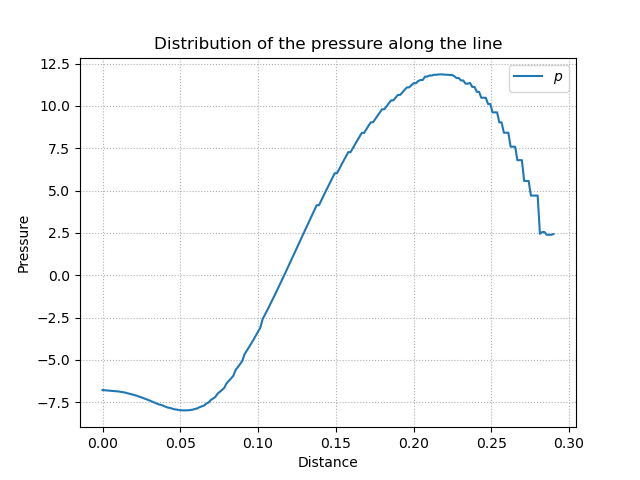

In [62]:
plt.figure()
plt.plot(sample_line_internalMesh['Distance'],sample_line_internalMesh['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the line')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [63]:
sample_line_cell = pv.DataSetFilters.sample_over_line(mesh_cell, A, B, resolution=200)

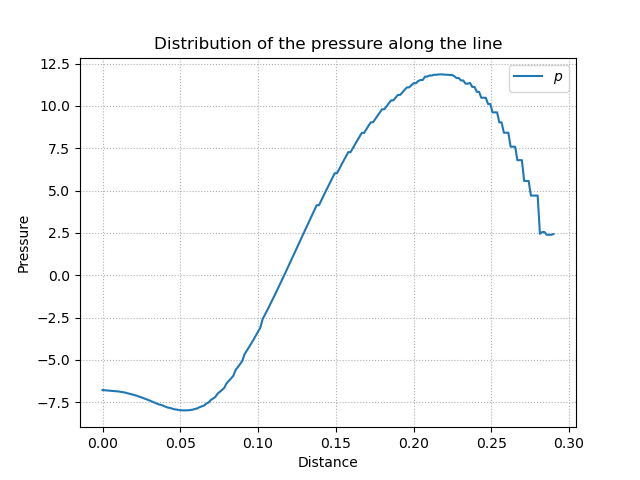

In [64]:
plt.figure()
plt.plot(sample_line_cell['Distance'],sample_line_cell['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the line')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [65]:
sample_line_point = pv.DataSetFilters.sample_over_line(mesh_point, A, B, resolution=200)

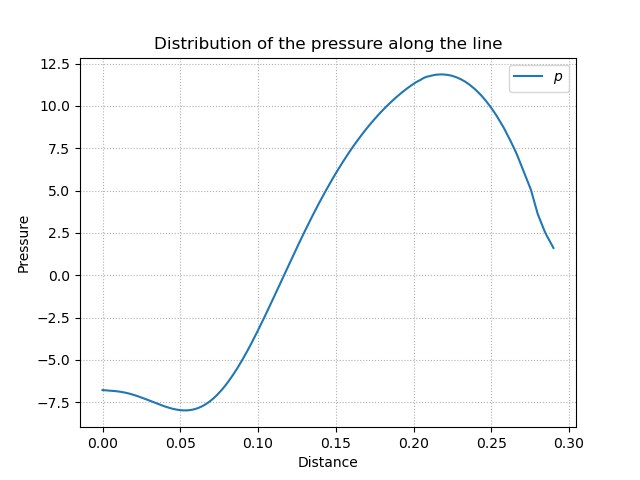

In [66]:
plt.figure()
plt.plot(sample_line_point['Distance'],sample_line_point['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the line')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

As you can see, the plots look much smoother when using point data over cell data. 

<a class="anchor" id="chapter14"></a>

# Plot a scalar over a circular arc

We can plot data from a circular arc too.<br/>
Similar to what we did for the straight line, this can be done for all the data we have, whether it's point data or cell data.<br/>
We'll do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [82]:
# Make two points at the bounds of the mesh and one at the center to
# construct a circular arc.
normal = [0, 0, 1]
polar = [0.02, 0, 0]
center = [0, 0, 0]
angle = 100.0

# Preview how this circular arc intersects this mesh
arc = pv.CircularArcFromNormal(center, 100, normal, polar, angle)

Let's see what's in the arc object.

In [68]:
arc

PolyData (0x1e191e8c0a0)
  N Cells:	1
  N Points:	101
  X Bounds:	-3.473e-03, 2.000e-02
  Y Bounds:	0.000e+00, 2.000e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

Let's show the arc in the computational domain:

In [83]:
p = pv.Plotter()
p.add_mesh(mesh_cell, style="wireframe", color="w")
p.add_mesh(arc, color="r")
a = arc.points[0]
b = arc.points[-1]
p.add_point_labels(
    [a, b], ["A", "B"], font_size=48, point_color="red", text_color="red"
)
p.view_xy()
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's make a plot overline.<br/>
First, we sample the data on the arc.<br/>
We do this for `internalMesh`, `mesh_cell` and `mesh_point`.

In [70]:
sample_arc_internal = pv.DataSetFilters.sample_over_circular_arc_normal(internalMesh,center,100,normal,polar,angle)

Then, we plot the data we want to visualize.<br/>
We can change the title, labels, grid style, etc. to match what we want.

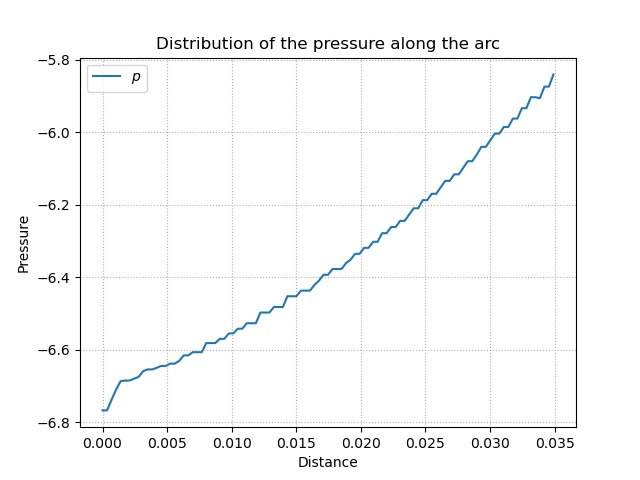

In [71]:
plt.figure()
plt.plot(sample_arc_internal['Distance'],sample_arc_internal['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [72]:
sample_arc_cell = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_cell,center,100,normal,polar,angle)

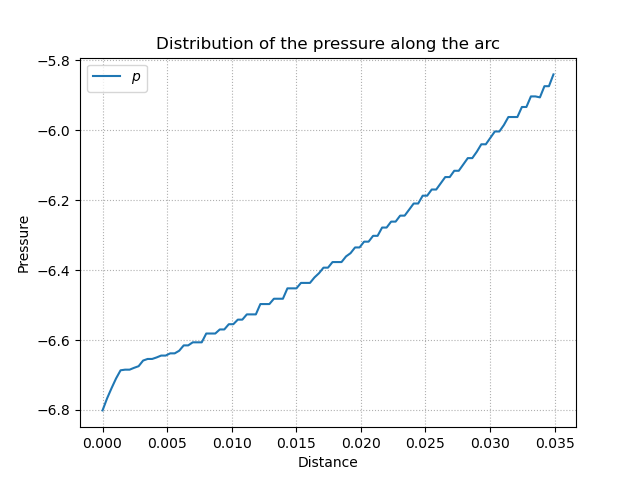

In [73]:
plt.figure()
plt.plot(sample_arc_cell['Distance'],sample_arc_cell['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [74]:
sample_arc_point = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_point,center,100,normal,polar,angle)

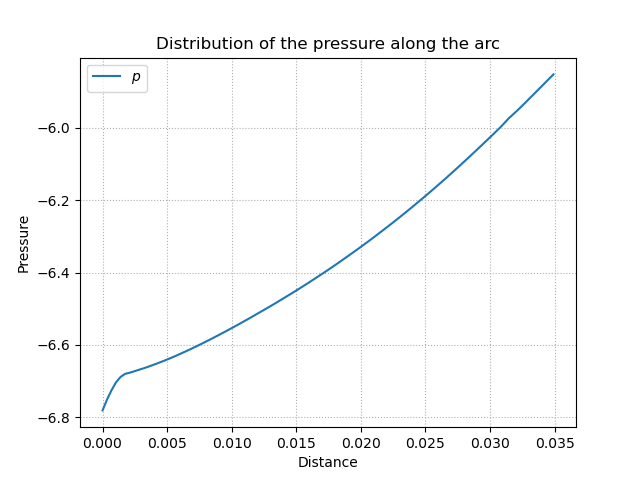

In [75]:
plt.figure()
plt.plot(sample_arc_point['Distance'],sample_arc_point['p'],label='$p$')
# note that we can show different variables on the same plot
plt.xlabel('Distance') 
plt.ylabel('Pressure')
plt.title('Distribution of the pressure along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

<a class="anchor" id="chapter15"></a>

# Wall shear stress

### This part of the code is still a work in progress!

In [76]:
#pdt_scal=np.dot(lower_wall_point.point_data["dux/dy"],lower_wall_point.point_data["Normals"])
#lower_wall_point.point_data["dux/dy"].shape
#pdt_scal

In [77]:
#visc=15.6e-6
#wss=visc*pdt_scal
#lower_wall_point.add_field_data(wss, 'wss')
#lower_wall_point

In [78]:
data_line = mesh_point.sample_over_line(A, B)
data_line

PolyData (0x1e197d217c0)
  N Cells:	1
  N Points:	37236
  X Bounds:	0.000e+00, 2.900e-01
  Y Bounds:	-1.500e-02, -1.500e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	38

In [79]:
data_line.save('data_line.vtp')